In [15]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
#import machine learning package
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn import linear_model, metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

In [23]:
sales_item = pd.read_csv('../data/items.csv')
sales_item_category = pd.read_csv('../data/item_categories.csv')
sales_shops = pd.read_csv('../data/shops.csv')
sales_test = pd.read_csv('../data/test.csv')

In [20]:
sales_train = pd.read_csv('../data/sales_train.csv', parse_dates=['date'], dtype={'date':'str', 'date_block_num':'int64', 'shop_id':'int64','item_id':'int64','item_price':'float64','item_cnt_day':'int64'})
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1
1,2013-03-01,0,25,2552,899.00,1
2,2013-05-01,0,25,2552,899.00,-1
3,2013-06-01,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


In [21]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.4 MB


In [24]:
print(sales_item.shape)
print(sales_item_category.shape)
print(sales_shops.shape)
print(sales_train.shape)
print(sales_test.shape)

(22170, 3)
(84, 2)
(60, 2)
(2935849, 6)
(214200, 3)


In [36]:
#checking null value
print('----Item----\n', sales_item.isnull().sum())
print('----Item Category----\n', sales_item_category.isnull().sum())
print('----Shops----\n', sales_shops.isnull().sum())
print('----Train----\n', sales_train.isnull().sum())
print('----Test----\n', sales_test.isnull().sum())

----Item----
 item_name           0
item_id             0
item_category_id    0
dtype: int64
----Item Category----
 item_category_name    0
item_category_id      0
dtype: int64
----Shops----
 shop_name    0
shop_id      0
dtype: int64
----Train----
 date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
----Test----
 ID         0
shop_id    0
item_id    0
dtype: int64


In [38]:
#check duplicate
sales_train[sales_train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-05-01,0,54,20130,149.0,1
1435367,2014-02-23,13,50,3423,999.0,1
1496766,2014-03-23,14,21,3423,999.0,1
1671873,2014-01-05,16,50,3423,999.0,1
1866340,2014-12-07,18,25,3423,999.0,1
2198566,2014-12-31,23,42,21619,499.0,1


In [39]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.4 MB


In [40]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [48]:
sales_dataset = sales_train.copy()

In [49]:
sales_dataset[sales_dataset['item_cnt_day']==2169]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169


In [69]:
sales_monthly = sales_dataset.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({'item_price':'mean','item_cnt_day':'sum'})

In [68]:
sales_monthly.head()

item_price  item_cnt_day
date_block_num shop_id item_id                          
0              0       32            221.0             6
                       33            347.0             3
                       35            247.0             1
                       43            221.0             1
                       51            128.5             2

<AxesSubplot:xlabel='date_block_num'>

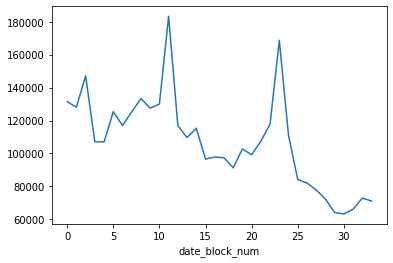

In [77]:
monthly_sales = sales_dataset.groupby(['date_block_num'])['item_cnt_day'].sum()
monthly_sales.plot()

<AxesSubplot:>

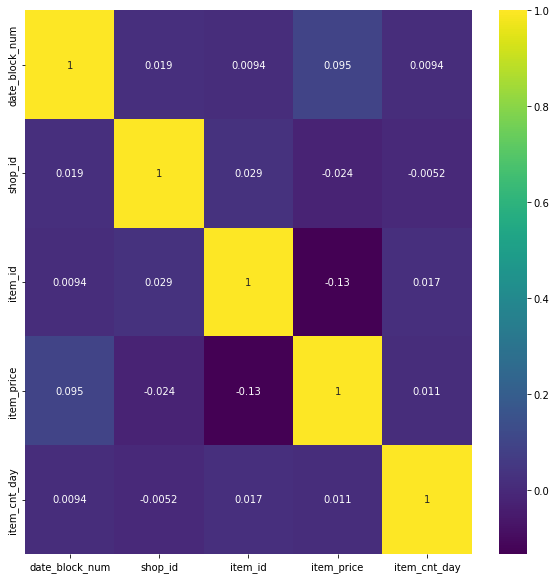

In [78]:
plt.figure(figsize = (10,10))

sns.heatmap(sales_dataset.corr(), cmap = 'viridis', annot = True)

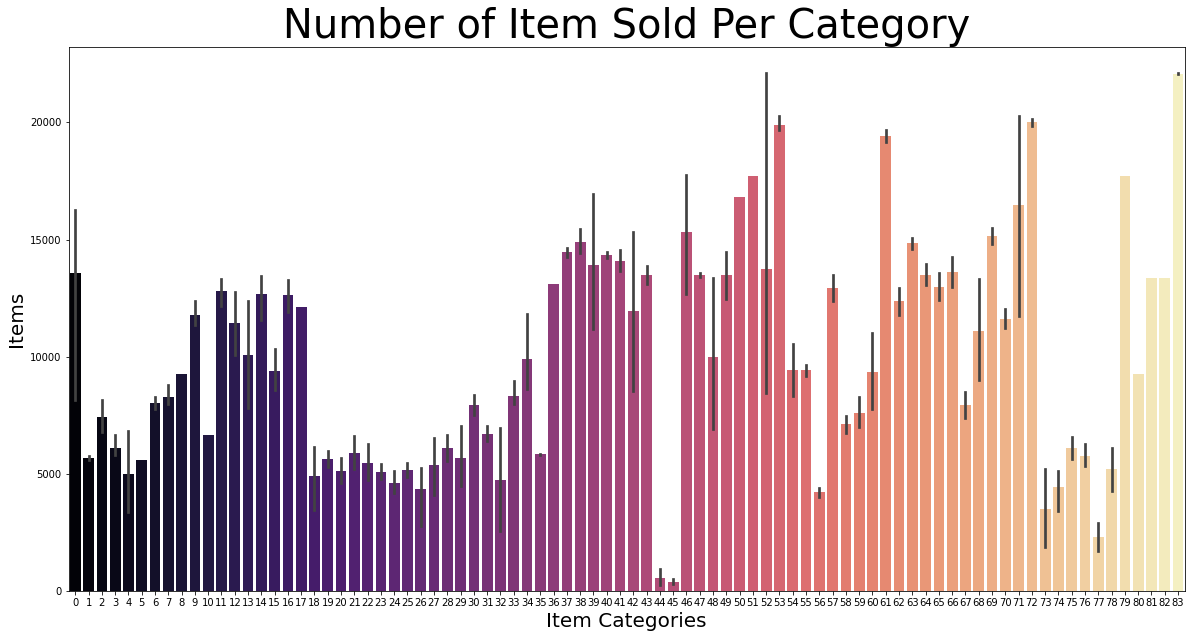

In [81]:
plt.figure(figsize = (20,10))
sns.barplot(sales_item['item_category_id'],sales_item['item_id'],palette='magma')
plt.title('Number of Item Sold Per Category', fontsize = 40)
plt.xlabel('Item Categories', fontsize = 20)
plt.ylabel('Items', fontsize = 20)
plt.show()

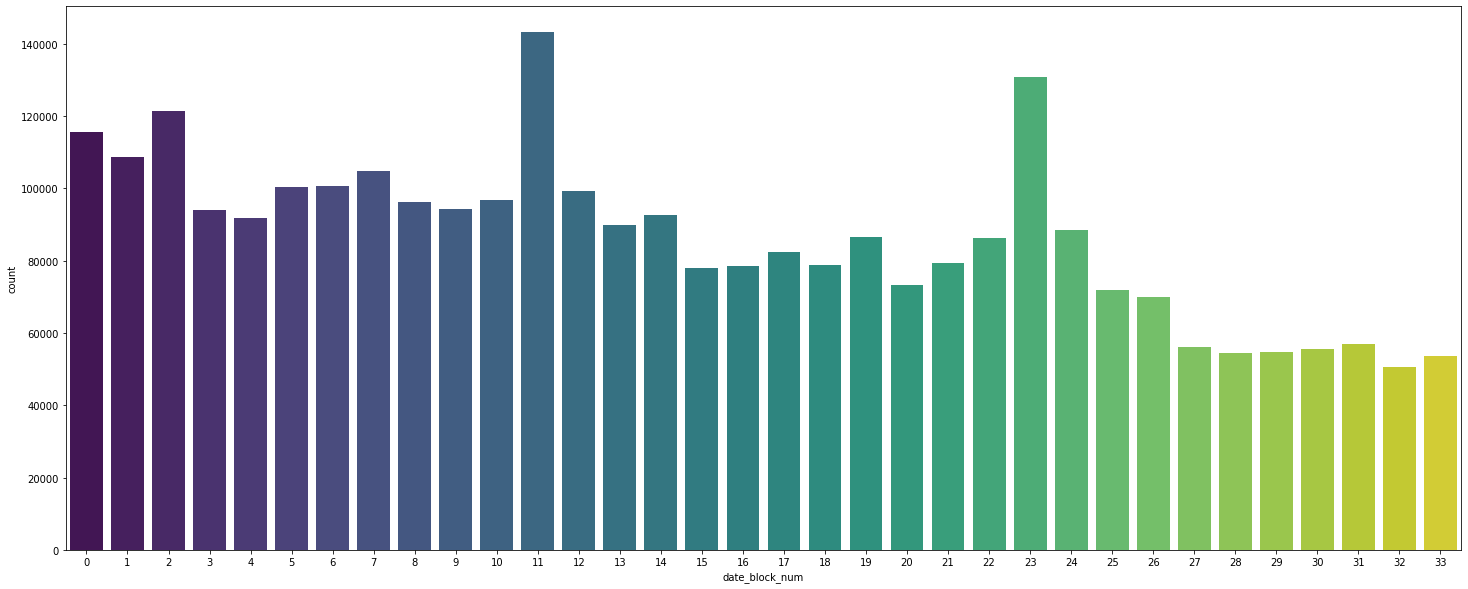

In [85]:
sns.countplot(sales_dataset['date_block_num'],palette='viridis')
plt.show()

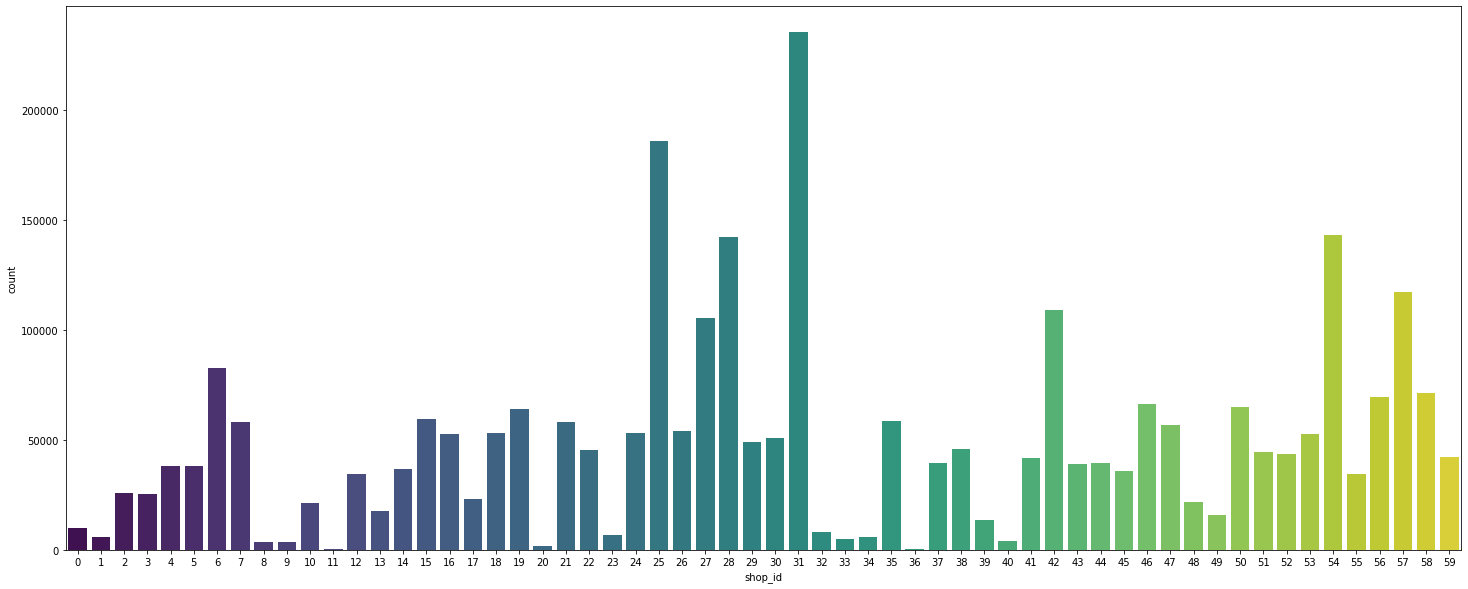

In [86]:
sns.countplot(sales_dataset['shop_id'],palette='viridis')
plt.show()

In [89]:
## Creating Date , Month and Year 

days = []
months = []
years = []

for day in sales_dataset['date']:
    days.append(day.day)
for month in sales_dataset['date']:
    months.append(month.month)
for year in sales_dataset['date']:
    years.append(year.year)

In [100]:
sales_dataset['day'] = days
sales_dataset['month'] = months
sales_dataset['year'] = years

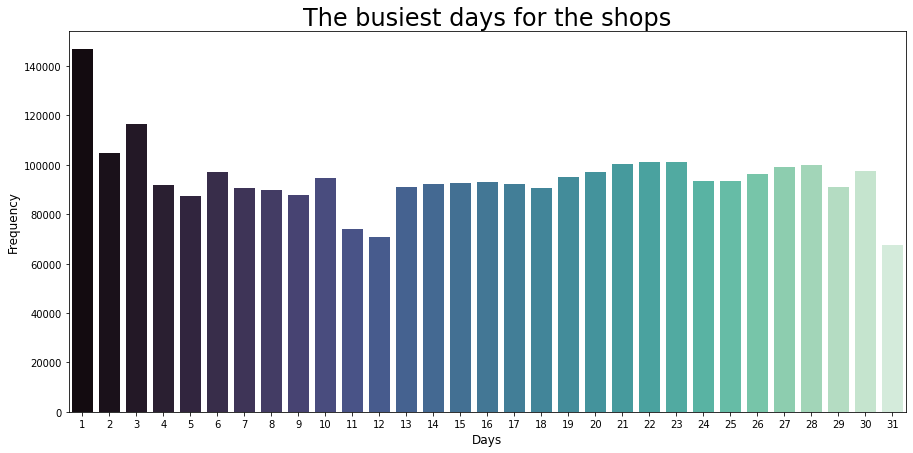

In [97]:
plt.figure(figsize = (15,7))
sns.countplot(days, palette= 'mako')
plt.title('The busiest days for the shops', fontsize = 24)
plt.xlabel('Days', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

Text(0, 0.5, 'Frequency')

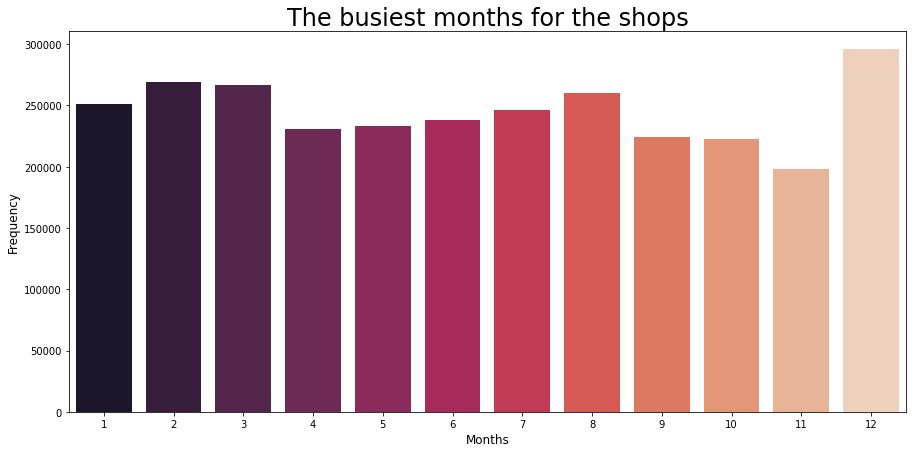

In [98]:
plt.figure(figsize = (15,7))
sns.countplot(months, palette= 'rocket')
plt.title('The busiest months for the shops', fontsize = 24)
plt.xlabel('Months', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

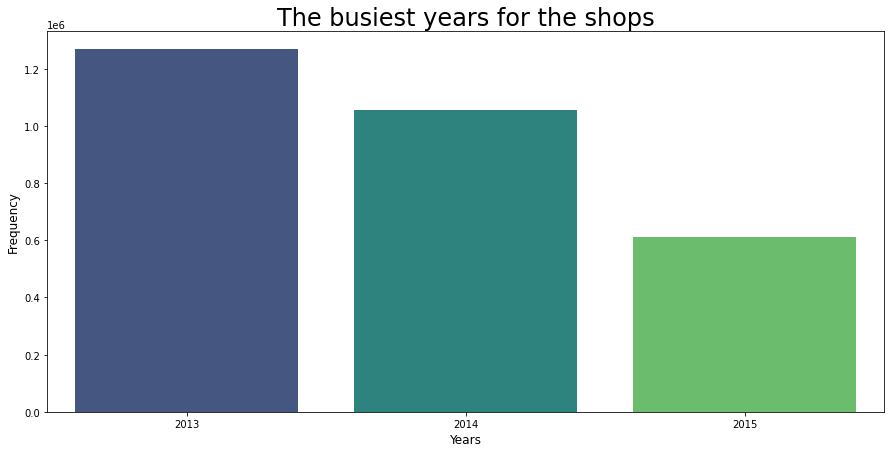

In [99]:
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(years, palette= 'viridis')
plt.title('The busiest years for the shops', fontsize = 24)
plt.xlabel('Years', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

In [101]:
sales_dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-02-01,0,59,22154,999.00,1,1,2,2013
1,2013-03-01,0,25,2552,899.00,1,1,3,2013
2,2013-05-01,0,25,2552,899.00,-1,1,5,2013
3,2013-06-01,0,25,2554,1709.05,1,1,6,2013
4,2013-01-15,0,25,2555,1099.00,1,15,1,2013


<AxesSubplot:xlabel='shop_id', ylabel='count'>

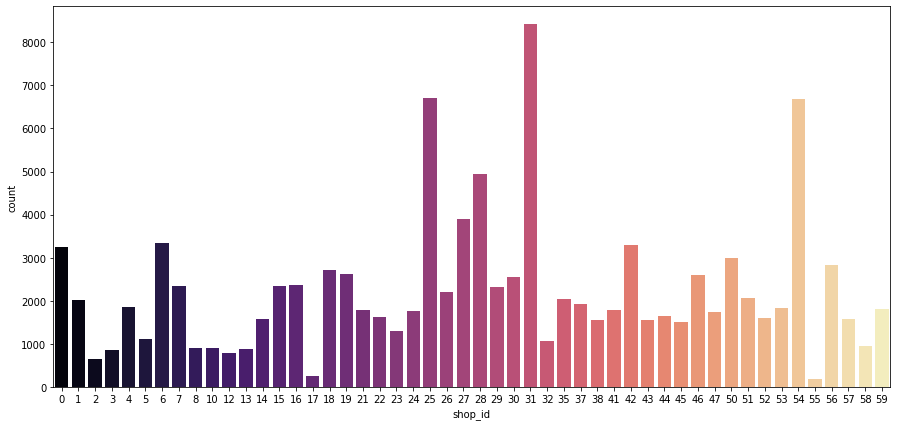

In [102]:
sns.countplot(sales_dataset[(sales_dataset.month == 2) & (sales_dataset.year == 2013)]['shop_id'], palette='magma')